# MLflow tracker tutorial

This tutorial demonstrates how to seamlessly integrate and transfer logs from MLflow to MLRun, </br>
creating a unified and powerful platform for your machine learning experiments.

MLflow and MLRun are two exceptional tools that, when combined, offer a comprehensive solution for managing, tracking, and deploying machine learning models. 

This notebook guides you through the process of:

1. Setting up the integration between MLflow and MLRun.
2. Extracting data, metrics, and artifacts from MLflow experiments.
3. Creating MLRun artifacts and projects to organize and manage the transferred data.
4. Leveraging MLRun's capabilities for model deployment and data processing.

By the end of this tutorial, you will have a understanding of how to establish a smooth flow of data between MLflow and MLRun.

In [13]:
! pip uninstall mlrun -y

Found existing installation: mlrun 0.0.0+unstable
Uninstalling mlrun-0.0.0+unstable:
  Successfully uninstalled mlrun-0.0.0+unstable


In [14]:
pip install -U git+https://github.com/ZeevRispler/mlrun.git@mlflow-track

  Cloning https://github.com/ZeevRispler/mlrun.git (to revision mlflow-track) to /tmp/pip-req-build-sz2k3yn7
  Running command git clone --filter=blob:none --quiet https://github.com/ZeevRispler/mlrun.git /tmp/pip-req-build-sz2k3yn7
  Running command git checkout -b mlflow-track --track origin/mlflow-track
  Switched to a new branch 'mlflow-track'
  Branch 'mlflow-track' set up to track remote branch 'mlflow-track' from 'origin'.
  Resolved https://github.com/ZeevRispler/mlrun.git to commit bc932259877b6896628e62d9f62168b7596f9f02
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached setuptools-68.2.2-py3-none-any.whl (807 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.3/161.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.6/138.6 kB 30.7 MB/s eta 0:00:00
  Created wheel for mlrun:

## Xgboost example function

In [1]:
%%writefile training.py

import mlflow
import mlflow.xgboost
import xgboost as xgb
from mlflow import log_metric
from sklearn import datasets
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split

def example_xgb_run():
    # Prepare train and test data
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Enable auto logging
    mlflow.xgboost.autolog()

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    with mlflow.start_run():
        # Train model
        params = {
            "objective": "multi:softprob",
            "num_class": 3,
            "learning_rate": 0.3,
            "eval_metric": "mlogloss",
            "colsample_bytree": 1.0,
            "subsample": 1.0,
            "seed": 42,
        }
        model = xgb.train(params, dtrain, evals=[(dtrain, "train")])
        
        # Evaluate model
        y_proba = model.predict(dtest)
        y_pred = y_proba.argmax(axis=1)
        loss = log_loss(y_test, y_proba)
        acc = accuracy_score(y_test, y_pred)
        
        # Log metrics by hand
        mlflow.log_metrics({"log_loss": loss, "accuracy": acc})

Overwriting training.py


## Mlrun code 

### Change the mlrun config to use the tracker


In [2]:
import mlrun

mlrun.mlconf.external_platform_tracking.enabled = True

> 2023-11-07 13:20:58,439 [warning] Failed resolving version info. Ignoring and using defaults
> 2023-11-07 13:21:00,435 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '1.5.2-rc1+track', 'client_version': '0.0.0+unstable'}


### Three options to run tracking:
- Set: `mlrun.mlconf.external_platform_tracking.mlflow.match_experiment_to_runtime` to True. This determines the run id and is the safest method
- Set the experiment name at: `mlflow.environment_variables.MLFLOW_EXPERIMENT_NAME.set`. This determines the experiment, you need to track the run added to it
- Just run it, then look across all experiments for added runs. This is not recommended.

### Create the project and function

In [3]:
# choose the first run option from above
mlrun.mlconf.external_platform_tracking.mlflow.match_experiment_to_runtime = True

# Create a project for this demo:
project = mlrun.get_or_create_project(name="mlflow-tracking-example", context="./")

# Create a MLRun function using the example train file (all the functions must be located in it):
training_func = project.set_function(
    func="training.py",
    name="example-xgb-run",
    kind="job",
    image="mlrun/mlrun",
)

> 2023-11-07 13:21:00,550 [info] Project loaded successfully: {'project_name': 'mlflow-tracking-example'}
> 2023-11-07 13:21:00,556 [warning] Failed to add git metadata, ignore if path is not part of a git repo.: {'path': './', 'error': '/User'}


### Run the function

After running the function, you can look at the UI and see all metrics and parameters are logged in mlrun.

In [4]:
# Run the example code using mlrun
train_run = training_func.run(
    local=True, handler="example_xgb_run",
)

> 2023-11-07 13:21:00,596 [info] Storing function: {'name': 'example-xgb-run-example-xgb-run', 'uid': 'ad1fec0b0df04083b034e3839460b623', 'db': 'http://mlrun-api:8080'}
[0]	train-mlogloss:0.74723
[1]	train-mlogloss:0.54060
[2]	train-mlogloss:0.40276
[3]	train-mlogloss:0.30789
[4]	train-mlogloss:0.24051
[5]	train-mlogloss:0.19086
[6]	train-mlogloss:0.15471
[7]	train-mlogloss:0.12807
[8]	train-mlogloss:0.10722
[9]	train-mlogloss:0.09053


2023/11/07 13:21:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlflow-tracking-example,...9460b623,0,Nov 07 13:21:00,completed,example-xgb-run-example-xgb-run,v3io_user=zeevrkind=localowner=zeevrhost=jupyter-zeev-8c4f96bdf-6j652mlflow-user=iguaziomlflow-run-name=unleashed-sow-351mlflow-run-id=bd94ff39bd4543b3b6351872a8600bb0mlflow-experiment-id=962295732764069350,,colsample_bytree=1.0custom_metric=Noneearly_stopping_rounds=Noneeval_metric=mloglosslearning_rate=0.3maximize=Nonenum_boost_round=10num_class=3objective=multi:softprobseed=42subsample=1.0verbose_eval=True,accuracy=1.0log_loss=0.06621863381213823train-mlogloss=0.09053360810503364,feature_importance_weight_jsonfeature_importance_weight_pngmodel


> 2023-11-07 13:21:19,604 [info] Run execution finished: {'status': 'completed', 'name': 'example-xgb-run-example-xgb-run'}


## Examine the results
You can also inspect the results using the UI.

In [5]:
train_run.outputs

{'accuracy': 1.0,
 'log_loss': 0.06621863381213823,
 'train-mlogloss': 0.09053360810503364,
 'feature_importance_weight_json': 'store://artifacts/mlflow-tracking-example/example-xgb-run-example-xgb-run_feature_importance_weight_json:ad1fec0b0df04083b034e3839460b623',
 'feature_importance_weight_png': 'store://artifacts/mlflow-tracking-example/example-xgb-run-example-xgb-run_feature_importance_weight_png:ad1fec0b0df04083b034e3839460b623',
 'model': 'store://artifacts/mlflow-tracking-example/example-xgb-run-example-xgb-run_model:ad1fec0b0df04083b034e3839460b623'}

In [6]:
train_run.status.results

{'accuracy': 1.0,
 'log_loss': 0.06621863381213823,
 'train-mlogloss': 0.09053360810503364}

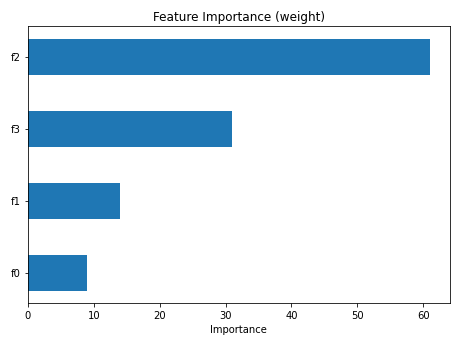

In [7]:
train_run.artifact("feature_importance_weight_png").show()

# Test this as a model server

### To use this as an model server we need to implement two functions, load and predict

In [8]:
%%writefile serving.py

import zipfile
from typing import Any, Dict, List, Union

import mlflow
import numpy as np
import os
import mlrun
from mlrun.serving.v2_serving import V2ModelServer
import xgboost as xgb
import pandas as pd

class MLFlowModelServer(V2ModelServer):
    """
    MLFlow tracker Model serving class, inheriting the V2ModelServer class for being initialized automatically by the model
    server and be able to run locally as part of a nuclio serverless function, or as part of a real-time pipeline.
    """

    def load(self):
        """
        loads an model that was logged by the MLFlow tracker model
        """
        # Unzip the model dir and then use mlflow's load function
        model_file, _ = self.get_model(".zip")
        model_path_unzip = model_file.replace(".zip", "")

        with zipfile.ZipFile(model_file, "r") as zip_ref:
            zip_ref.extractall(model_path_unzip)
            
        self.model = mlflow.pyfunc.load_model(model_path_unzip)

    def predict(self, request: Dict[str, Any]) -> list:
        """
        Infer the inputs through the model. The inferred data will
        be read from the "inputs" key of the request.

        :param request: The request to the model using xgboost's predict. 
                The input to the model will be read from the "inputs" key.

        :return: The model's prediction on the given input.
        """
        
        # Get the inputs and set to accepted type:
        inputs = pd.DataFrame(request["inputs"])

        # Predict using the model's predict function:
        predictions = self.model.predict(inputs)

        # Return as list:
        return predictions.tolist()


Overwriting serving.py


### Create the server and serving function

In [9]:
serving_func = project.set_function(
    func="serving.py",
    name="example-xgb-server",
    kind="serving",
    image="mlrun/mlrun",
)

> 2023-11-07 13:21:19,690 [warning] Failed to add git metadata, ignore if path is not part of a git repo.: {'path': './', 'error': '/User'}


In [10]:
# Add the model
serving_func.add_model("mlflow_xgb_model", class_name="MLFlowModelServer", model_path=train_run.outputs["model"])

In [11]:
# Create a mock server
server = serving_func.to_mock_server()

> 2023-11-07 13:21:19,833 [info] model mlflow_xgb_model was loaded
> 2023-11-07 13:21:19,834 [info] Loaded ['mlflow_xgb_model']


### Test the model 

In [12]:
# An example taken randomly from the dataset the model was trained on
x = [[5.1, 3.5, 1.4, 0.2]]
result = server.test("/v2/models/mlflow_xgb_model/predict", {"inputs": x})

In [13]:
# look at the result 
result

{'id': '4188f3585d9d42b7b184324f713c9c26',
 'model_name': 'mlflow_xgb_model',
 'outputs': [[0.9505813121795654, 0.025876399129629135, 0.02354232780635357]]}

# Offline tests

This example runs a function that's being logged by mlflow without mlrun.
Afterwards you import it into MLRun.

In [14]:
%%writefile offline_training.py

import mlflow
import mlflow.xgboost
import xgboost as xgb
from mlflow import log_metric
from sklearn import datasets
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split

mlflow.environment_variables.MLFLOW_EXPERIMENT_NAME.set("example_xgb_run")

# The function you run that is logged by mlflow
def example_xgb_run():
    # Prepare train and test data
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Enable auto logging
    mlflow.xgboost.autolog()

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    with mlflow.start_run():
        # Train model
        params = {
            "objective": "multi:softprob",
            "num_class": 3,
            "learning_rate": 0.3,
            "eval_metric": "mlogloss",
            "colsample_bytree": 1.0,
            "subsample": 1.0,
            "seed": 42,
        }
        model = xgb.train(params, dtrain, evals=[(dtrain, "train")])
        
        # Evaluate model
        y_proba = model.predict(dtest)
        y_pred = y_proba.argmax(axis=1)
        loss = log_loss(y_test, y_proba)
        acc = accuracy_score(y_test, y_pred)
        
        # log metrics by hand
        mlflow.log_metrics({"log_loss": loss, "accuracy": acc})

Overwriting offline_training.py


In [15]:
import sys
import os
sys.path.insert(0, os.path.abspath("./"))
from offline_training import example_xgb_run
import mlrun
from mlrun.track.trackers.mlflow_tracker import MLFlowTracker
import tempfile
import mlflow
# Allow all tracking
mlrun.mlconf.external_platform_tracking.enabled = True

## Import offline run

In [16]:

# Create a project for this demo:
project = mlrun.get_or_create_project(name="mlflow-tracking-example", context="./")

# Create a MLRun function that you will log in to:
function_name = "example-xgb-run"

training_func = project.set_function(
    func="offline_training.py",
    name=function_name,
    kind="job",
    image="mlrun/mlrun",
)

> 2023-11-07 13:21:33,092 [info] Project loaded successfully: {'project_name': 'mlflow-tracking-example'}
> 2023-11-07 13:21:33,100 [warning] Failed to add git metadata, ignore if path is not part of a git repo.: {'path': './', 'error': '/User'}


In [20]:
# Create a temporary working area to avoid junk in your working area    
with tempfile.TemporaryDirectory() as test_directory:
    mlflow.set_tracking_uri(test_directory)  # Tell mlflow where to save logged data

    # Run mlflow wrapped code
    example_xgb_run()

    # Set mlconf path to artifacts
    mlrun.mlconf.artifact_path = test_directory + "/artifact"
    
    # Find the lastest mlflow run
    mlflow_run = mlflow.last_active_run()
    
    # Import the run into mlrun using the function you created earlier
    imported_run = MLFlowTracker().import_run(
        project=project,
        reference_id=mlflow_run.info.run_id,
        function_name=function_name,
    )



[0]	train-mlogloss:0.74723
[1]	train-mlogloss:0.54060
[2]	train-mlogloss:0.40276
[3]	train-mlogloss:0.30789
[4]	train-mlogloss:0.24051
[5]	train-mlogloss:0.19086
[6]	train-mlogloss:0.15471
[7]	train-mlogloss:0.12807
[8]	train-mlogloss:0.10722
[9]	train-mlogloss:0.09053
> 2023-11-07 13:22:37,911 [info] logging run results to: http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...d9046639,0,Nov 07 13:22:37,running,serious-swan-748,host=jupyter-zeev-8c4f96bdf-6j652mlflow-user=iguaziomlflow-run-name=serious-swan-748mlflow-run-id=baea30472f94402b80359f7cd9046639mlflow-experiment-id=386053050020337317,,objective=multi:softprobnum_class=3learning_rate=0.3eval_metric=mloglosscolsample_bytree=1.0subsample=1.0seed=42num_boost_round=10maximize=Noneearly_stopping_rounds=Noneverbose_eval=Truecustom_metric=None,train-mlogloss=0.09053360810503364log_loss=0.06621863381213823accuracy=1.0,feature_importance_weight_jsonfeature_importance_weight_pngmodel


## Import offline model

In [ ]:
# Create a temporary working area to avoid junk in your working area    
with tempfile.TemporaryDirectory() as test_directory:
    mlflow.set_tracking_uri(test_directory)  # Tell mlflow where to save logged data

    # Run mlflow wrapped code
    example_xgb_run()
    
    # Create a project for this tester:
    project = mlrun.get_or_create_project(name="default", context=test_directory)

    # Access the model's uri through mlflow's last run
    mlflow_run = mlflow.last_active_run()
    model_uri = mlflow_run.info.artifact_uri + "/model"

    key = "test_model"
    MLFlowTracker().import_model(
        project=project,
        reference_id=model_uri,
        key=key,
        metrics=mlflow_run.data.metrics,
    )

    # Validate the model was logged into project
    assert project.get_artifact(key)

[0]	train-mlogloss:0.74723
[1]	train-mlogloss:0.54060
[2]	train-mlogloss:0.40276
[3]	train-mlogloss:0.30789
[4]	train-mlogloss:0.24051
[5]	train-mlogloss:0.19086
[6]	train-mlogloss:0.15471
[7]	train-mlogloss:0.12807
[8]	train-mlogloss:0.10722
[9]	train-mlogloss:0.09053
